In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [5]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [7]:
eps = 0.25

## Testing the box method

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

In [8]:
rand_range = lambda size, max_, min_: (max_-min_)*np.random.random_sample(size=size) + min_

In [9]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays, get_stay_indices
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [10]:
from synthetic_data.trajectory_class import get_trajectory

In [11]:
segs_plot_kwargs = {'linestyle':'--', 'marker':'o', 'color':'k', 'linewidth':4.0, 'markerfacecolor':'w', 'markersize':6.0, 'markeredgewidth':2.0}

In [12]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [128]:
def check_times(stay_time_bounds, stay_xlocs, time_thresh = 1/6):
    
    new_stay_time_bounds = []
    new_stay_xlocs = []
    for n in range(len(stay_xlocs)):

        nn = 2*n
        b0,b1 = stay_time_bounds[nn],stay_time_bounds[nn+1]

        if b1-b0 > time_thresh: 

            new_stay_time_bounds.extend([b0,b1])
            new_stay_xlocs.append(stay_xlocs[n])
        else:
            #print(f'Dropping stays (too short): {(b1-b0):.4f}')            
            pass
        
    return new_stay_time_bounds, new_stay_xlocs            

In [129]:
def check_locs(new_stay_time_bounds, new_stay_xlocs, loc_thresh = 0.5):

    final_stay_time_bounds = []
    final_stay_xlocs = []

    current_len = len(new_stay_xlocs)
    n=0
    while n < current_len-1:

        x1, x2 = new_stay_xlocs[n], new_stay_xlocs[n+1]

        nn = 2*n
        if abs(x1-x2) < loc_thresh: 
            #print(f'Dropping stays (too near): {abs(x1-x2):.4f}')
            final_stay_time_bounds.extend([new_stay_time_bounds[nn],new_stay_time_bounds[nn+3]])
            final_stay_xlocs.append(0.5*(x1+x2))
            n+=1

        else:
            final_stay_time_bounds.extend([new_stay_time_bounds[nn],new_stay_time_bounds[nn+1]])
            final_stay_xlocs.append(x1)        
        n+=1

        if n==current_len-1:        
            nn = 2*n
            final_stay_time_bounds.extend([new_stay_time_bounds[nn],new_stay_time_bounds[nn+1]])
            final_stay_xlocs.append(new_stay_xlocs[n]) 

    return final_stay_time_bounds, final_stay_xlocs

In [157]:
def get_rand_stays(time_thresh, loc_thresh):
    

    nr_stays = np.random.randint(10)
    stay_time_bounds = np.concatenate((np.array([0]),rand_range(2*nr_stays, 24, 0),np.array([24])))
    stay_time_bounds = np.sort(stay_time_bounds)
    stay_xlocs = rand_range(nr_stays+1, 2, - 2.0)

    time_thresh = 1/6 # 10 mins

    new_stay_time_bounds, new_stay_xlocs = check_times(stay_time_bounds, stay_xlocs, time_thresh)
    
    new_stay_time_bounds, new_stay_xlocs = check_locs(new_stay_time_bounds, new_stay_xlocs, loc_thresh)

    stays = []
    for n in range(int(len(new_stay_time_bounds)/2)):
        nn = 2*n
        stay = get_stay(new_stay_time_bounds[nn], new_stay_time_bounds[nn+1], new_stay_xlocs[n])
        stays.append(stay)    

    return stays

In [170]:
def get_rand_traj():

    dsec = 1/3600.0
    time = np.arange(0,24,dsec)

    event_frac = rand_range(1,0.01,0.001)[0]
    duplicate_frac = rand_range(1,0.3,0.05)[0]

    configs = {
        'threshold':0.5,
        'event_frac':event_frac,
        'duplicate_frac':duplicate_frac,    
        'noise_min':0.02,
        'noise_max':1.15
    }

    loc_thresh = 0.5
    time_thresh = 1/6
    
    stays = []
    while len(stays)==0:
        stays  = get_rand_stays(time_thresh, loc_thresh)

    time_arr, raw_arr, noise_arr = get_trajectory(stays, time, configs)
    segments = get_segments(time, stays, threshold=loc_thresh)
    
    return time_arr, raw_arr, noise_arr, segments

In [155]:
def check_locs(stay_time_bounds, stay_xlocs, loc_thresh = 0.5):

    diffs = lambda x_arr: [abs(m-n)<loc_thresh for m,n in zip(x_arr[:-1],x_arr[1:])]
    
    #print(diffs(stay_xlocs),any(diffs(stay_xlocs)))

    current_len = len(stay_xlocs)

    
    new_stay_time_bounds = stay_time_bounds
    new_stay_xlocs = stay_xlocs

    work_stay_time_bounds = new_stay_time_bounds
    work_stay_xlocs = new_stay_xlocs

    while any(diffs(new_stay_xlocs)):

        new_stay_time_bounds = []
        new_stay_xlocs = []
        
        current_len = len(work_stay_xlocs)
        n=0
        while n < current_len-1:

            x1, x2 = work_stay_xlocs[n], work_stay_xlocs[n+1]

            nn = 2*n
            if abs(x1-x2) < loc_thresh: 
                #print(f'Dropping stays (too near): {abs(x1-x2):.4f}')
                new_stay_time_bounds.extend([work_stay_time_bounds[nn],work_stay_time_bounds[nn+3]])
                new_stay_xlocs.append(0.5*(x1+x2))
                n+=1

            else:
                new_stay_time_bounds.extend([work_stay_time_bounds[nn],work_stay_time_bounds[nn+1]])
                new_stay_xlocs.append(x1)        
            n+=1

            if n==current_len-1:        
                nn = 2*n
                new_stay_time_bounds.extend([work_stay_time_bounds[nn],work_stay_time_bounds[nn+1]])
                new_stay_xlocs.append(work_stay_xlocs[n]) 

        work_stay_time_bounds = new_stay_time_bounds
        work_stay_xlocs = new_stay_xlocs
    
        #print(diffs(new_stay_xlocs),any(diffs(new_stay_xlocs)))    
        
    return new_stay_time_bounds, new_stay_xlocs

In [165]:
get_rand_stays(1/6, 0.25)

[{'type': 'stay',
  'loc': -0.11301425786540342,
  'start': 0.0,
  'end': 3.2744730799977777,
  'slope': 0},
 {'type': 'stay',
  'loc': -0.9446518479816106,
  'start': 5.950590423635138,
  'end': 7.833684849230016,
  'slope': 0},
 {'type': 'stay',
  'loc': -1.780471569315072,
  'start': 8.452955603409265,
  'end': 10.97279064218955,
  'slope': 0},
 {'type': 'stay',
  'loc': -0.6900862356925557,
  'start': 11.398949517963892,
  'end': 13.621894290135202,
  'slope': 0},
 {'type': 'stay',
  'loc': 0.9762957050692282,
  'start': 13.920305042889364,
  'end': 14.781612998113207,
  'slope': 0},
 {'type': 'stay',
  'loc': -1.7019421783720912,
  'start': 15.124087031501574,
  'end': 17.106247691749836,
  'slope': 0},
 {'type': 'stay',
  'loc': -0.07940436100762183,
  'start': 17.529039666789632,
  'end': 19.370500052375036,
  'slope': 0},
 {'type': 'stay',
  'loc': 0.39552098972982375,
  'start': 19.373588208744795,
  'end': 19.60409745174705,
  'slope': 0},
 {'type': 'stay',
  'loc': -1.702130

In [156]:
check_locs([1,2,3,4,5,6,7,8,9,10,11,12,13,14], [0,0,0,2,1.9,1.8,1.7])

([1, 6, 7, 14], [0.0, 1.85])

In [171]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj()
new_stays = get_adjusted_stays(segments, time_arr)
new_t_segs, new_x_segs = get_stay_segs(new_stays)

In [172]:
from numpy.linalg import lstsq

In [173]:
import pickle
from datetime import datetime

In [174]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

In [175]:
stays_tag = int((new_x_segs.size)/3)
date_tag = datetime.today().strftime('%Y%m%d')
notes = 'unconverging_example'
trajectory_tag = f"{date_tag}_trajectory_{stays_tag}stays__{notes}"

In [176]:
trajectory = {}
trajectory['segments'] = segments
trajectory['time_arr'] = time_arr
trajectory['raw_locs_arr'] = raw_arr
trajectory['nse_locs_arr'] = noise_arr

In [177]:
#pickle.dump( trajectory, open( trajectory_tag, "wb" ) )
#trajectory = pickle.load( open( "20200625_trajectory_8stays__adjusted.pkl", "rb" ) )

in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1
in loop 1


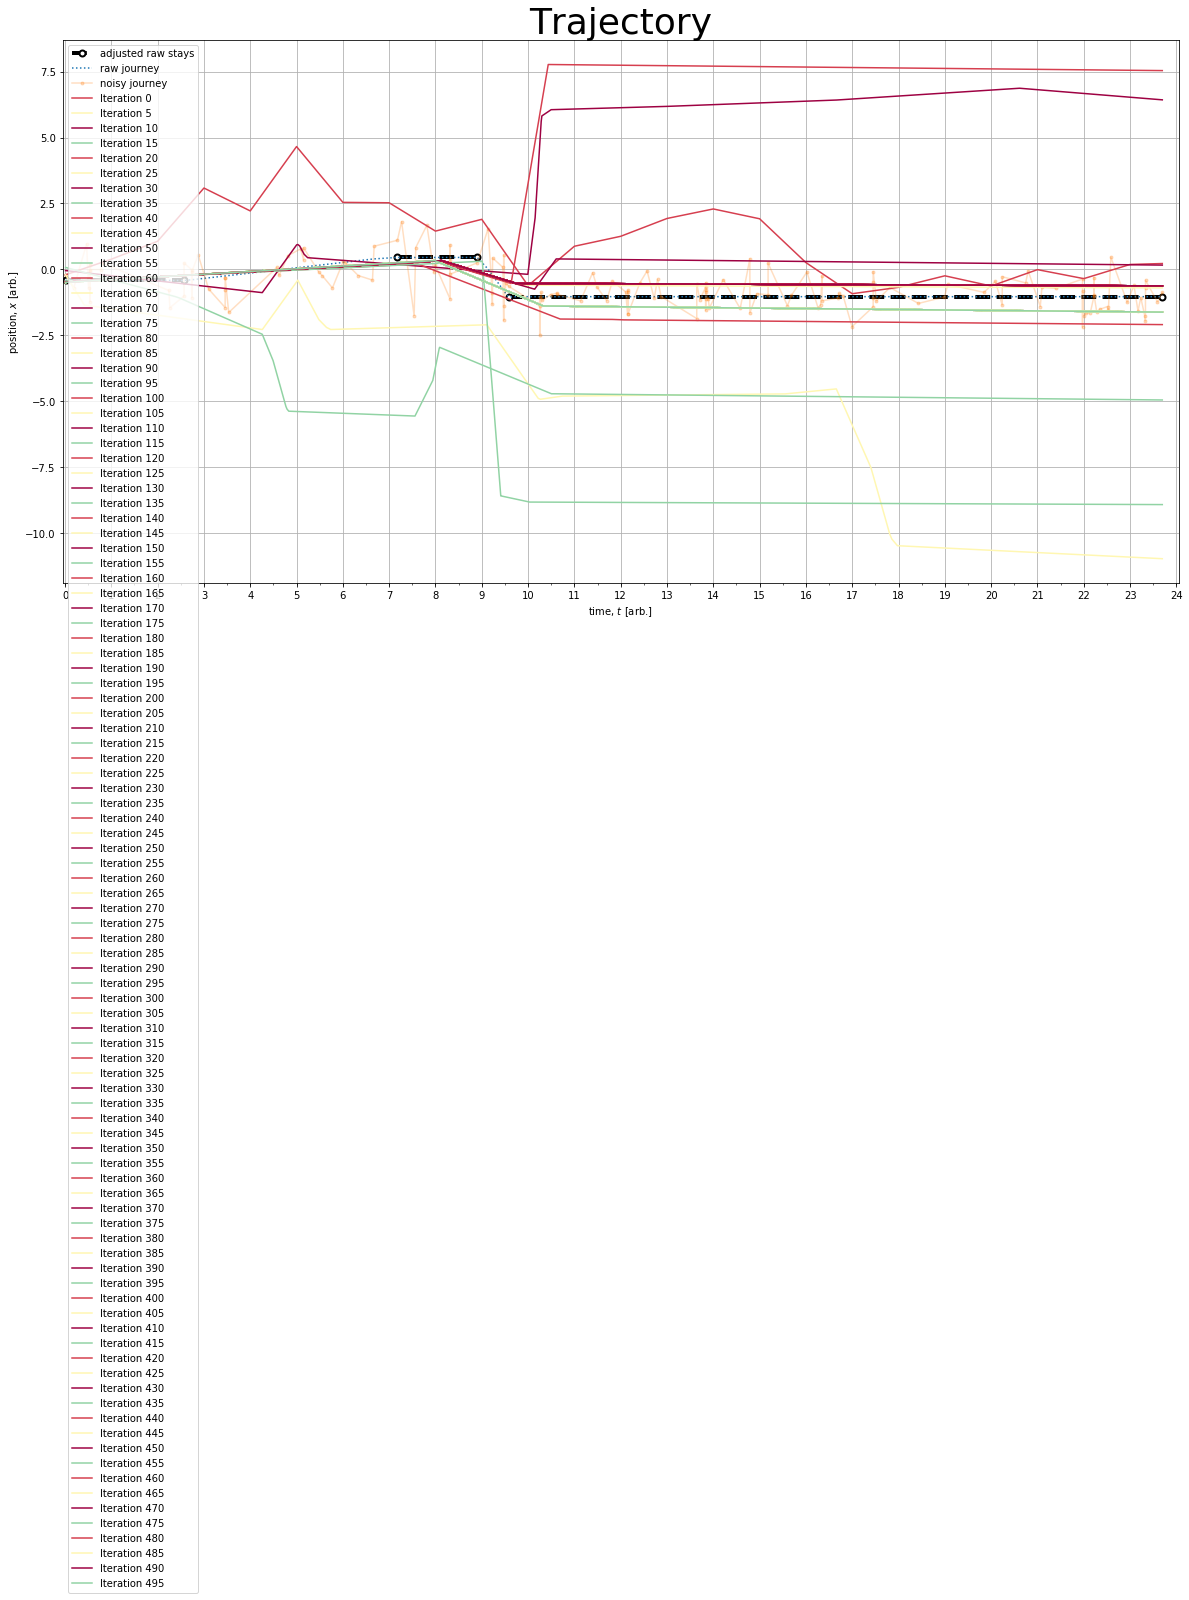

In [178]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_arr, raw_arr, ':', label='raw journey')
plt.plot(time_arr, noise_arr, '.-', label='noisy journey', alpha=0.25)

# hyperparam
nIterationMax = 500

# Sorting the breaks
#breakpoints = np.sort( np.array(breakpoints0) )
breakpoints = np.arange(0,24,1)

# time_arrDiffs
dt = np.min( np.diff(np.unique( time_arr)) )

ones = np.ones_like(time_arr)

yyysolution_last = noise_arr

all_breakpoints = []

loops1 = []
cycle = []
last_len = 0
set_len = 0
# loop through the whole data set
for i in range( nIterationMax ):
    
    #print(yyysolution_last.shape)
    
    ones = np.ones_like(time_arr)
    
    # Linear regression:  solve A*p = Y
    Rk = [ramp( time_arr - xk ) for xk in breakpoints ]
    Sk = [step( time_arr - xk ) for xk in breakpoints ]
    A = np.array([ ones, time_arr ] + Rk + Sk )
    p =  lstsq(A.transpose(), noise_arr, rcond=None)[0] 

    # Parameters identification:
    a, b = p[0:2]
    ck = p[ 2:2+len(breakpoints) ]
    dk = p[ 2+len(breakpoints): ]

    # Estimation of the next break-points:
    newBreakpoints = breakpoints - dk/ck 

    #print(np.max(np.abs(newBreakpoints - breakpoints)),dt/5, dt)
    # Stop condition
    if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
        print('Stopping criterion')
        #break
    
        
    # Compute the final segmented fit:
    xxxsolution = np.insert( np.append( breakpoints, max(time_arr) ), 0, min(time_arr) )
    ones =  np.ones_like(xxxsolution) 
    Rk = [ c*ramp( xxxsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    yyysolution = a*ones + b*xxxsolution + np.sum( Rk, axis=0 )

    # Compute the final segmented fit:
    ones_model =  np.ones_like(time_arr) 
    Rk_model = [ c*ramp( time_arr - x0 ) for x0, c in zip(breakpoints, ck) ]

    yyysolution_model = a*ones_model + b*time_arr + np.sum( Rk_model, axis=0 )
    
    norm_err = np.linalg.norm(yyysolution_model-yyysolution_last)
    round_norm_err = round(norm_err,5)
    if round_norm_err in loops1:

        cycle.append(round_norm_err)
        set_len = len(list(set(cycle)))
        consec = True
        print("in loop", set_len)        
    else:    
        loops1.append(round_norm_err)
        consec = False
    
    
    
    
    #print(norm_err, yyysolution.size, breakpoints.size )
    if np.linalg.norm(yyysolution_model-yyysolution_last) < 0.01:
        print(f'{i}: Stopping criterion #2')
        
    #print(yyysolution.shape)
    if i%5==0:
        plt.plot(xxxsolution, yyysolution, color=colors[i%len(colors)] , label=f'Iteration {i}')
    
    breakpoints = newBreakpoints
    breakpoints = breakpoints[(breakpoints > time_arr.min()) & (breakpoints < time_arr.max())]
    breakpoints = np.sort( breakpoints )
    all_breakpoints.append(breakpoints)
    yyysolution_last = yyysolution_model
    
    if len(cycle) > 0:
        if (last_len == set_len) & consec & (round_norm_err == min(cycle)):
            break
    else:
        last_len = set_len
    

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_arr.min()-1*eps
ymax = noise_arr.max()+1*eps
#plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True);    

In [23]:
(len(all_breakpoints),all_breakpoints[-1].size)

(500, 20)

In [24]:
all_breakpoints[0]

array([ 0.39321545,  2.05170389,  3.92398398,  4.18231188,  4.62743351,
        4.63328542,  7.20185747,  7.50820759,  9.96276426, 11.11677672,
       11.446974  , 12.16494935, 12.87683329, 13.8034818 , 13.82280615,
       15.74635057, 16.33515047, 16.83932632, 17.74106053, 19.69441506,
       20.64513236, 22.853558  , 23.27761768])

In [26]:
plot_all_breakpoints = np.empty(shape=(len(all_breakpoints),all_breakpoints[-1].size))
plot_all_breakpoints[:,:] = np.NaN

In [27]:
for n,row in enumerate(all_breakpoints):
    #print(row)
    if row.size == all_breakpoints[-1].size:
        plot_all_breakpoints[n,:] = row

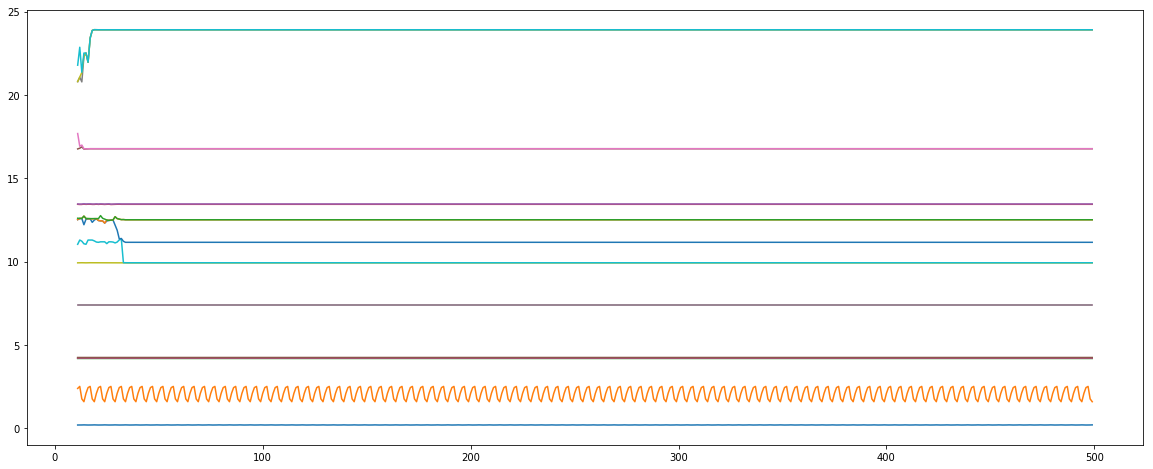

In [28]:
plt.figure(figsize=[20,8])
plt.plot(plot_all_breakpoints);

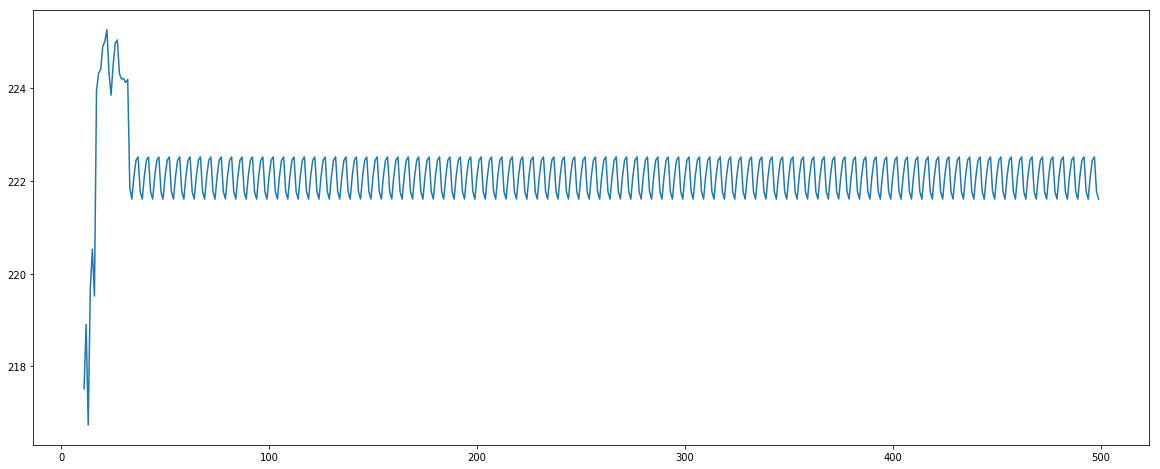

In [29]:
plt.figure(figsize=[20,8])
plt.plot(np.sum(plot_all_breakpoints, axis=1));

**Note** sometimes the errors don't converge; make the breakpoints do?

### Eval

In [30]:
calc_slope = lambda x1,y1,x2,y2: (y2-y1)/(x2-x1)

In [31]:
final_pairs = []
for n in range(0,len(yyysolution)-1,1):
    
    slope = calc_slope(xxxsolution[n],yyysolution[n],xxxsolution[n+1],yyysolution[n+1])
    
    print(slope)
    
    mask = np.where((time_arr >= xxxsolution[n]) & (time_arr < xxxsolution[n+1]))
    
    if abs(slope) < 0.1:
        final_pairs.append((mask[0][0],mask[0][-1]))

-1.5610942031502228
0.04270029550252649
-0.01328645908051477
-14.709430127600365
-29.413986806041127
-14.691477185776192
0.02505628992408342
0.5305777828166687
1.036099275658243
0.10906441528124876
-0.8179704451005734
-1.0525655360919177
-0.5402904052608694
-0.028015274352695237
0.31984362516800996
0.6677025246785134
0.333855934571531
9.344517717501787e-06
0.11112199246356526
0.2222346404757925
0.3333472887025269


In [32]:
from synthetic_data.trajectory import get_stay_indices

In [33]:
true_indices = get_stay_indices(new_stays, time_arr)

In [34]:
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

np.sum(true_labels), true_labels.size-np.sum(true_labels), true_labels.size, np.sum(true_labels)/true_labels.size

In [35]:
pred_labels = np.zeros(time_arr.shape)
for pair in final_pairs:
    pred_labels[pair[0]:pair[1]+1] = 1

In [36]:
np.sum(pred_labels), pred_labels.size-np.sum(pred_labels), pred_labels.size, np.sum(pred_labels)/pred_labels.size

(459.0, 274.0, 733, 0.626193724420191)

In [37]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

confusion_matrix(true_labels, pred_labels)

array([[249,   1],
       [ 25, 458]])

In [38]:
precision_score(true_labels, pred_labels), recall_score(true_labels, pred_labels), 

(0.9978213507625272, 0.94824016563147)

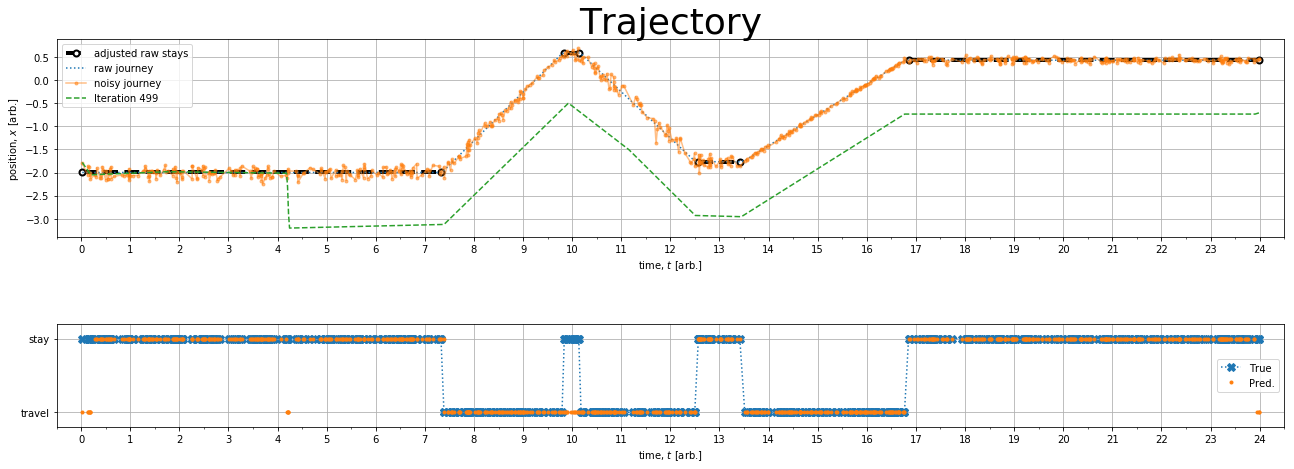

In [39]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(2,1,1)

ax1.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax1.plot(time_arr, raw_arr, ':', label='raw journey')
ax1.plot(time_arr, noise_arr, '.-', label='noisy journey', alpha=0.5)
        
ax1.plot(xxxsolution, yyysolution, '--', label=f'Iteration {i}')
        

ax1.legend();

ax1.set_xlabel(r'time, $t$ [arb.]')
ax1.set_ylabel(r'position, $x$ [arb.]')

ymin = noise_arr.min()-1*eps
ymax = noise_arr.max()+1*eps
#plt.ylim(ymin, ymax)

ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))

ax1.set_xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

ax1.set_title('Trajectory', fontsize=36)
ax1.grid(visible=True);    

ax2 = fig.add_subplot(2,1,2, adjustable='box', aspect=1.5, sharex=ax1)

ax2.plot(time_arr, true_labels, 'X:', markersize=8, label='True')
ax2.plot(time_arr, pred_labels, '.', label='Pred.')
ax2.set_ylim(-0.2,1.2)
ax2.set_xlim(-0.5,24.5)

'''ax = plt.gca()

ax2.xaxis.set_major_locator(MultipleLocator(1))

#ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
'''
plt.xlabel(r'time, $t$ [arb.]')

ax2.set_yticks([0,1])
ax2.set_yticklabels(['travel', 'stay'])
ax2.legend()
#ax2.set_title('Trajectory', fontsize=36)
ax2.grid(visible=True);    

In [166]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [167]:
datetag = datetime.today().strftime('%Y%m%d')

In [168]:
### pickle.dump( trajectory, open( trajectory_tag, "wb" ) )
#trajectory = pickle.load( open( "20200625_trajectory_8stays__adjusted.pkl", "rb" ) )

In [179]:
prec_scores, reca_scores = [], []

nnnn = 0

while nnnn < 100:
    
    if nnnn%10 == 0: print(nnnn)
    try:
        
        # Create data
        time_arr, raw_arr, noise_arr, segments = get_rand_traj()
        new_stays = get_adjusted_stays(segments, time_arr)
        new_t_segs, new_x_segs = get_stay_segs(new_stays) 
        
        min_t, max_t = time_arr.min(), time_arr.max()

        fig = plt.figure(figsize=(22,8))
        ax1 = fig.add_subplot(2,1,1)

        # The adjusted raw-stays
        ax1.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
        ax1.plot(time_arr, noise_arr, '.-', color='gray', label='noisy trajectory', alpha=0.25)
        ax1.plot(time_arr, raw_arr, ':', color='C0', label='raw trajectory')
        
        
        # hyperparam
        nIterationMax = 100

        # Sorting the breaks
        #breakpoints = np.sort( np.array(breakpoints0) )
        breakpoints = np.arange(0,24,1)

        # time_arrDiffs
        dt = np.min( np.diff(np.unique( time_arr)) )

        ones = np.ones_like(time_arr)

        yyysolution_last = noise_arr


        loops1 = []
        cycle = []
        last_len = 0
        set_len = 0
        # loop through the whole data set
        for i in range( nIterationMax ):

            #print(yyysolution_last.shape)

            ones = np.ones_like(time_arr)

            # Linear regression:  solve A*p = Y
            Rk = [ramp( time_arr - xk ) for xk in breakpoints ]
            Sk = [step( time_arr - xk ) for xk in breakpoints ]
            A = np.array([ ones, time_arr ] + Rk + Sk )
            p =  lstsq(A.transpose(), noise_arr, rcond=None)[0] 

            # Parameters identification:
            a, b = p[0:2]
            ck = p[ 2:2+len(breakpoints) ]
            dk = p[ 2+len(breakpoints): ]

            # Estimation of the next break-points:
            newBreakpoints = breakpoints - dk/ck 

            #print(np.max(np.abs(newBreakpoints - breakpoints)),dt/5, dt)
            # Stop condition
            #if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            #    print('Stopping criterion')
            #    #break


            # Compute the final segmented fit:
            xxxsolution = np.insert( np.append( breakpoints, max(time_arr) ), 0, min(time_arr) )
            ones =  np.ones_like(xxxsolution) 
            Rk = [ c*ramp( xxxsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

            yyysolution = a*ones + b*xxxsolution + np.sum( Rk, axis=0 )

            # Compute the final segmented fit:
            ones_model =  np.ones_like(time_arr) 
            Rk_model = [ c*ramp( time_arr - x0 ) for x0, c in zip(breakpoints, ck) ]

            yyysolution_model = a*ones_model + b*time_arr + np.sum( Rk_model, axis=0 )

            norm_err = np.linalg.norm(yyysolution_model-yyysolution_last)
            round_norm_err = round(norm_err,5)
            if round_norm_err in loops1:

                cycle.append(round_norm_err)
                set_len = len(list(set(cycle)))
                consec = True
                #print("in loop", set_len)        
            else:    
                loops1.append(round_norm_err)
                consec = False

            #print(norm_err, yyysolution.size, breakpoints.size )
            #if np.linalg.norm(yyysolution_model-yyysolution_last) < 0.01:
            #    print(f'{i}: Stopping criterion #2')

            breakpoints = newBreakpoints
            breakpoints = breakpoints[(breakpoints > time_arr.min()) & (breakpoints < time_arr.max())]
            breakpoints = np.sort( breakpoints )

            yyysolution_last = yyysolution_model

            if len(cycle) > 0:
                if (last_len == set_len) & consec & (round_norm_err == min(cycle)):
                    print(f'{i}: Stopping criterion #3')
                    break
            else:
                last_len = set_len

                
        #=======================================================                
        ax1.plot(xxxsolution, yyysolution, '--', color='C1', lw=4, alpha=0.5, label=f'Iteration {i}')


        ax1.legend();

        ax1.set_xlabel(r'time, $t$ [arb.]')
        ax1.set_ylabel(r'position, $x$ [arb.]')

        ymin = noise_arr.min()-1*eps
        ymax = noise_arr.max()+1*eps
        #plt.ylim(ymin, ymax)

        ax1.xaxis.set_major_locator(MultipleLocator(1))
        ax1.xaxis.set_minor_locator(MultipleLocator(0.5))

        ax1.set_xlim(-0.05, 24.05)
        #plt.xlim(-0.1, 19.1
        #plt.xlim(15.1, 19.1)

        ax1.set_title('Trajectory', fontsize=18)
        ax1.grid(visible=True);  
        #=======================================================
        
        #print(len(yyysolution))
        
        final_pairs = []
        for n in range(0,len(yyysolution)-1,1):
            
            slope = calc_slope(xxxsolution[n],yyysolution[n],xxxsolution[n+1],yyysolution[n+1])

            mask = np.where((time_arr >= xxxsolution[n]) & (time_arr < xxxsolution[n+1]))

            if (abs(slope) < 0.1) & (mask[0].size != 0):
                final_pairs.append((mask[0][0],mask[0][-1]))

        true_indices = get_stay_indices(new_stays, time_arr)
        true_labels = np.zeros(time_arr.shape)

        for pair in true_indices:
            true_labels[pair[0]:pair[1]+1] = 1

        pred_labels = np.zeros(time_arr.shape)
        for pair in final_pairs:
            pred_labels[pair[0]:pair[1]+1] = 1


        prec = precision_score(true_labels, pred_labels)
        rec  = recall_score(true_labels, pred_labels)
        
        #=======================================================
        stays_tag = int((new_x_segs.size)/3)
        date_tag = datetime.today().strftime('%Y%m%d')
        notes = 'precrec_study_extranoise'
        
        trajectory_tag = f"{date_tag}_trajectory_{stays_tag}stays__{notes}"
        trajectory = {}
        trajectory['segments'] = segments
        trajectory['time_arr'] = time_arr
        trajectory['raw_locs_arr'] = raw_arr
        trajectory['nse_locs_arr'] = noise_arr
        
        outdir = f"./{date_tag}__trajectories__{notes}/"
        if os.path.isdir(outdir)==False:
            os.mkdir(outdir)
            
        pr_tag = f'__prec_{prec:.4f}_rec_{rec:.4f}'.replace('.','o')            
        pickle.dump( trajectory, open(outdir + trajectory_tag + pr_tag +'.pkl', "wb" ) )
        
        #=======================================================                    
        ax2 = fig.add_subplot(2,1,2, adjustable='box', aspect=1.5, sharex=ax1)

        ax2.plot(time_arr, true_labels, 'X:', markersize=8, label='True')
        ax2.plot(time_arr, pred_labels, '.', label='Pred.')
        ax2.set_ylim(-0.2,1.2)
        ax2.set_xlim(-0.5,24.5)

        plt.xlabel(r'time, $t$ [arb.]')

        ax2.set_yticks([0,1])
        ax2.set_yticklabels(['travel', 'stay'])
        ax2.legend()
        ax2.set_title('Classes', fontsize=18)
        ax2.grid(visible=True); 
        
        plt.suptitle(f'Trajectory, prec.: {prec:.4f}, rec. {rec:.4f}', fontsize=24)
        plt.savefig(outdir + trajectory_tag + pr_tag + '.png')
        plt.close()
        #=======================================================            


        
        #print(precision_score(true_labels, pred_labels))
        #confusion_matrix(true_labels, pred_labels)
        prec_scores.append(prec)
        reca_scores.append(rec)
        
        
        
        nnnn+=1
    except:
        print('failed')
        pass
    
    #nnnn+=1

0
10
20
30
failed
30
40


/home/sandm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in double_scalars


50
failed
60
70
failed
80


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


90
failed


In [58]:
os.path.isdir('./test')

True

In [60]:
if os.path.isdir('./test')==False:
    os.mkdir('./test', )

In [54]:
reca_scores

[0.9704579025110783,
 0.8608247422680413,
 0.9260969976905312,
 0.5,
 0.9657701711491442,
 0.9173553719008265,
 0.9887640449438202,
 0.43283582089552236,
 0.9940119760479041,
 0.8859649122807017]

In [81]:
preciss = np.array(prec_scores)
recalls = np.array(reca_scores)

#print(preciss.mean(), recalls.mean())
recaprec = np.hstack([recalls.reshape(-1,1),preciss.reshape(-1,1)])
recaprec = recaprec[recaprec[:,0].argsort()]

In [82]:
preciss.mean(), (1-recalls).mean()

(0.8732896228971392, 0.14475514481781354)

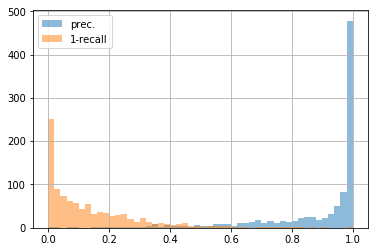

In [83]:
binw = 0.02
bins=np.arange(0,1.0+binw,binw)
_ = plt.hist(preciss, bins=bins, alpha=0.5, label='prec.')
_ = plt.hist(1-recalls, bins=bins, alpha=0.5, label='1-recall')
plt.legend()
plt.grid();

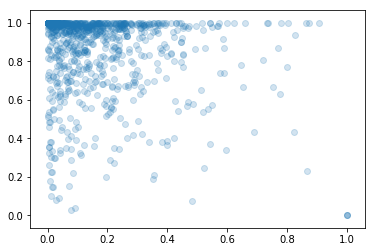

In [85]:
plt.scatter(1.-recaprec[:,0], recaprec[:,1], alpha=0.2)